In [111]:
import os
from pathlib import Path


def open_filepath(filePath):
    try:
        abs_path = Path(os.path.abspath(filePath))
        with open(abs_path, "r") as file:
            lines_list = file.readlines()
            return lines_list
    except FileNotFoundError:
        print(f"Error: File not found at {abs_path}")
        print(f"Current working directory: {os.getcwd()}")
    return []

def separate_sequences(filepath):
    res = []
    text = open_filepath(filepath)
    curr_seq = []
    for line in text:
        if line == '\n':
            if curr_seq:
                res.append(curr_seq)
            curr_seq = []
        else:
            curr_seq.append(line.strip('\n'))
    if curr_seq:
        res.append(curr_seq)
    return res

def separate_observation_label(filepath):
    data = separate_sequences(filepath)
    return [[line.split() for line in seq] for seq in data]

train_data = separate_observation_label("EN/train")
dev_in_data = separate_sequences("EN/dev.in")
dev_out_data = separate_observation_label("EN/dev.out")

### Part 1

In [112]:
def emission_mle(data: list[list[tuple[str, str]]]) -> dict:
    emission_prob = {}
    tags = {}
    for seq in data:
        for word, tag in seq:
            if tag not in tags:
                tags[tag] = {"count": 0, "words": {}}
            tags[tag]["count"] += 1
            tags[tag]["words"][word] = tags[tag]["words"].get(word, 0) + 1
    for tag in tags:
        emission_prob[tag] = {}
        for word in tags[tag]["words"]:
            emission_prob[tag][word] = tags[tag]["words"][word] / tags[tag]["count"]
    return emission_prob

In [113]:
def smooth(data: list[list[tuple[str, str]]], k: int = 3) -> dict:
    UNK = "#UNK#"
    tags = {}
    replaced = {}
    res_data = []

    for seq in data:
        for word,tag in seq:
            if tag not in tags:
                tags[tag] = {}
            tags[tag][word] = tags[tag].get(word, 0) + 1

    for tag in tags:
        if tag not in replaced:
            replaced[tag] = set()
        for word in tags[tag]:
            if tags[tag][word] < k:
                replaced[tag].add(word)

    for seq in data:
        smooth_seq = list()
        for i in range(len(seq)):
            tag = seq[i][1]
            word = UNK if seq[i][0] in replaced[tag] else seq[i][0]
            smooth_seq.append((word, tag))
        res_data.append(smooth_seq)
    return res_data


def smooth_emission_MLE(data: list[list[tuple[str, str]]], k: int = 3) -> dict:
    data = smooth(data, k)
    res = emission_mle(data)
    return res


def predict(inp_data, out_file, emission):
    words = set()
    res = []
    UNK = "#UNK#"
    def_tag = max(emission.keys(), key=lambda tag: emission[tag].get(UNK, 0))

    for tag in emission:
        words |= set(emission[tag].keys())

    for seq in inp_data:
        pred_seq = []
        for word in seq:
            pred_tag = max(emission.keys(), key = lambda tag: emission[tag].get(word, 0)) if word in words else def_tag
            pred_seq.append((word, pred_tag))
        res.append(pred_seq)

    with open(out_file, "w") as f:
        for seq in res:
            for word, tag in seq:
                f.write(f"{word} {tag}\n")
            f.write("\n")

predict(dev_in_data, "EN/dev.p1.out", smooth_emission_MLE(train_data))

part 1 eval result:

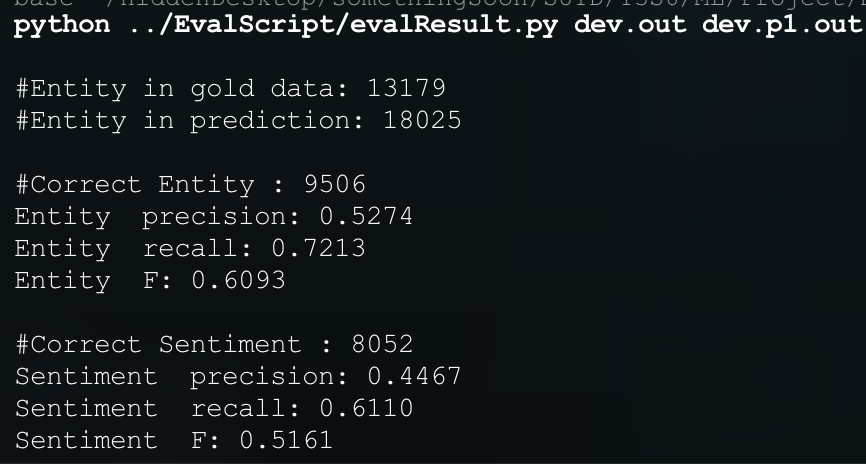

### Part 2

In [114]:
def transition_mle(data):
    tags = {}
    count = {}

    START_S = "START"
    STOP_S = "STOP"

    for seq in data:
        prev_state = START_S
        for _, curr_state in seq:
            if prev_state not in tags:
                tags[prev_state] = {}
            tags[prev_state][curr_state] = tags[prev_state].get(curr_state, 0) + 1
            count[prev_state] = count.get(prev_state, 0) + 1
            prev_state = curr_state

        if prev_state not in tags:
            tags[prev_state] = {}

        tags[prev_state][STOP_S] = tags[prev_state].get(STOP_S, 0) + 1

    for tag in tags:
        for transit_tag in tags[tag]:
            tags[tag][transit_tag] /= count[tag]
    return tags

In [115]:
def clean_data(inp_data, words):
    UNK = "#UNK#"
    data = []

    for i in range(len(inp_data)):
        data.append(inp_data[i] if inp_data[i] in words else UNK)

    return data

def viterbi(inp_data: list[str], a: dict, b: dict) -> list:

    res = []

    START_S = "START"
    STOP_S = "STOP"

    states = list(b.keys())
    words = set(word for tag in b for word in b[tag])
    data = clean_data(inp_data, words)

    N = len(data)
    T = len(states)

    # init score matrix (hold scores from start (0) -> 1 to n -> (not including stop (n+1))
    score_m = [[0] * T for _ in range(N)] 
    backpointer = [[0] * T for _ in range(N)]

    # start of seq
    for t in range(T):
        score_m[0][t] = a[START_S].get(states[t], 0) * b[states[t]].get(data[0], 0)

    # recurse for scores of each state at each step
    for j in range(1, N):
        for t in range(T):
            best_score = 0
            best_state = 0
            for s in range(T):
                curr_score = score_m[j-1][s] * a[states[s]].get(states[t], 0) * b[states[t]].get(data[j], 0)
                if curr_score > best_score:
                    best_score = curr_score
                    best_state = s
            score_m[j][t] = best_score
            backpointer[j][t] = best_state

    # end of sequence
    last_best_score = 0
    last_state_index = 0
    for t in range(len(states)):
        curr_score = score_m[N-1][t] * a[states[t]].get(STOP_S, 0)
        if curr_score > last_best_score:
            last_best_score = curr_score
            last_state_index = t

    res.insert(0, states[last_state_index])

    # backtracking
    for j in range(N-1, 0, -1):
        best_score = 0
        probable_state = 0
        for t in range(T):
            curr_score = score_m[j][t] * a[states[t]].get(res[0], 0)
            if curr_score > best_score:
                best_score = curr_score
                probable_state = backpointer[j][t]
        res.insert(0, states[probable_state])

    return res

def predict_viterbi(inp_data: list, train_data: list[list[tuple[str, str]]], v, out_file: str):

    # init params
    a = transition_mle(train_data)
    b = smooth_emission_MLE(train_data)

    res = []
    for ob_seq in inp_data:
        pred_state_seq = v(ob_seq, a, b)
        res.append(pred_state_seq)

    with open(out_file, "w") as f:
        for ob_seq, seq in zip(inp_data, res):
            for word, tag in zip(ob_seq, seq):
                f.write(f"{word} {tag}\n")
            f.write("\n")

predict_viterbi(dev_in_data, train_data, viterbi, "EN/dev.p2.out")

Part 2 eval result:

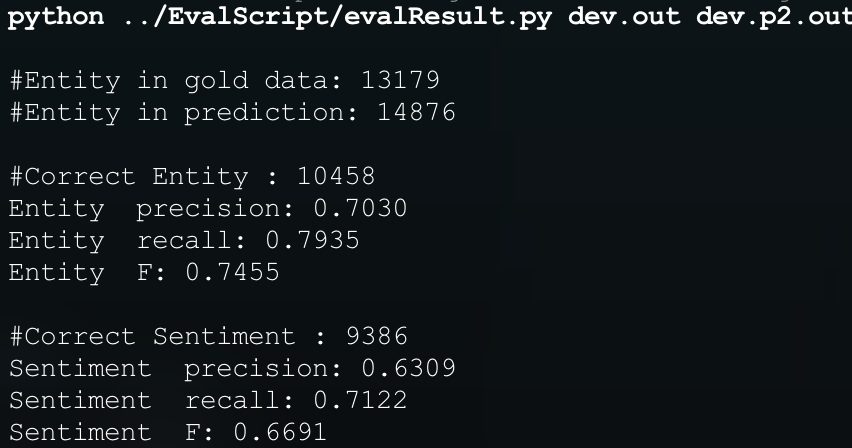

### Part 3

In [139]:
# hold array of four
# in inner recursion, if better, keep comparing, then insert at index, and pop last one

def kth_best_viterbi(inp_data: list, a, b, k=4):

    START_S = "START"
    STOP_S = "STOP"

    res = [[] for _ in range(k)]

    states = list(b.keys())
    words = set(word for tag in b for word in b[tag])
    data = clean_data(inp_data, words)

    N = len(data)
    T = len(states)

    # init score matrix (hold scores from start (0) -> 1 to n -> (not including stop (n+1))
    score_m = [[[0] * k for _ in range(T)] for _ in range(N)] 
    backpointer = [[[0] * k for _ in range(T)] for _ in range(N)]

    # start of seq
    for t in range(T):
        curr_score = a[START_S].get(states[t], 0) * b[states[t]].get(data[0], 0)
        replace_index = k
        for i in range(k - 1, -1, -1): # best is at index 0 
            if curr_score > score_m[0][t][i]:
                replace_index = i
        if replace_index < k:
            score_m[0][t].insert(replace_index, curr_score)
            score_m[0][t].pop()

    # recurse for scores of each state at each step
    for j in range(1, N):
        for t in range(T):
            best_scores = [0] * k
            best_states = [0] * k
            for s in range(T):
                for p in range(k):
                    curr_score = score_m[j - 1][s][p] * a[states[s]].get(states[t], 0) * b[states[t]].get(data[j], 0)
                    replace_index = k
                    for i in range(k - 1, -1, -1):
                        if curr_score > best_scores[i]:
                            replace_index = i
                    if replace_index < k:
                        best_scores.insert(replace_index, curr_score)
                        best_scores.pop()
                        best_states.insert(replace_index, s)
                        best_states.pop()
            score_m[j][t] = best_scores
            backpointer[j][t] = best_states

    # end of sequence
    last_best_scores = [0] * k
    last_state_indices = [0] * k
    for t in range(len(states)):
        for p in range(k):
            curr_score = score_m[N - 1][t][p] * a[states[t]].get(STOP_S, 0)
            replace_index = k
            for i in range(k-1, -1, -1):
                if curr_score > last_best_scores[i]:
                    replace_index = i
            if replace_index < k:
                last_best_scores.insert(replace_index, curr_score)
                last_best_scores.pop()
                last_state_indices.insert(replace_index, t)
                last_state_indices.pop()

    for i in range(k):
        res[i].insert(0, states[last_state_indices[i]])

    for i in range(k):  # for each of the four final best paths
        curr_state_index = last_state_indices[i]
        curr_path = [states[curr_state_index]]
        curr_k = i
        for j in range(N - 1, 0, -1):
            curr_state_index = backpointer[j][curr_state_index][curr_k]
            curr_path.insert(0, states[curr_state_index])
        res[i] = curr_path

    return res[k - 1]

def fourth_best_viterbi(inp_data: list, a, b):
    return kth_best_viterbi(inp_data, a, b, k=4)

predict_viterbi(dev_in_data, train_data, fourth_best_viterbi, "EN/dev.p3.out")

#### Fourth best tag sequence:

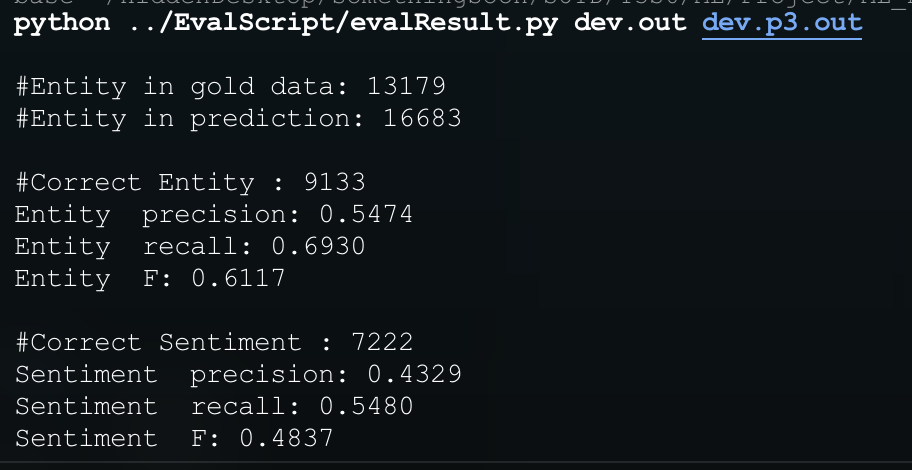

#### Third best tag sequence:

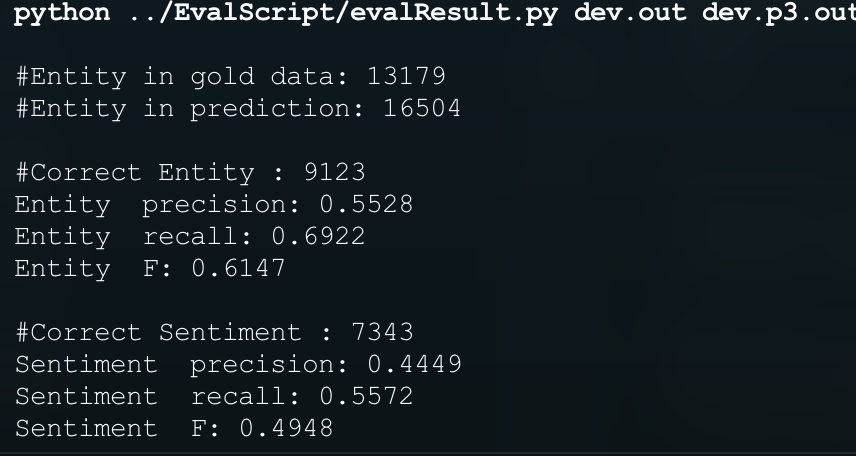

#### Second best tag sequence:

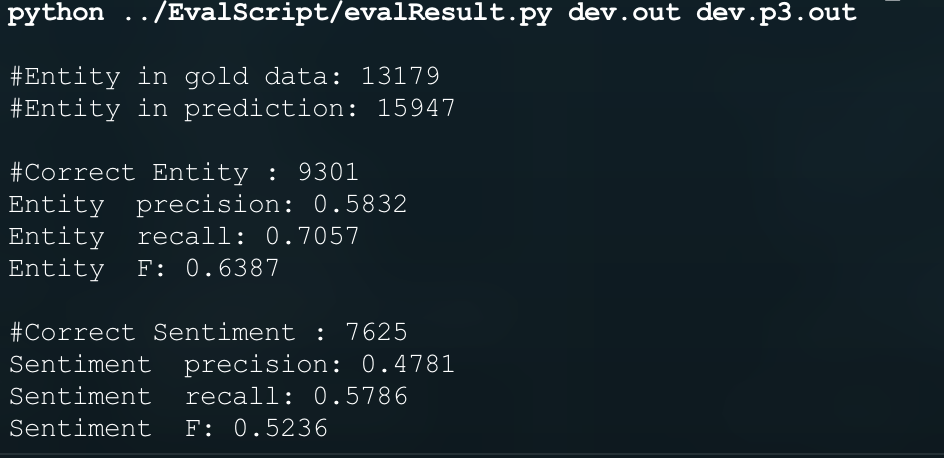

#### Best tag sequence:

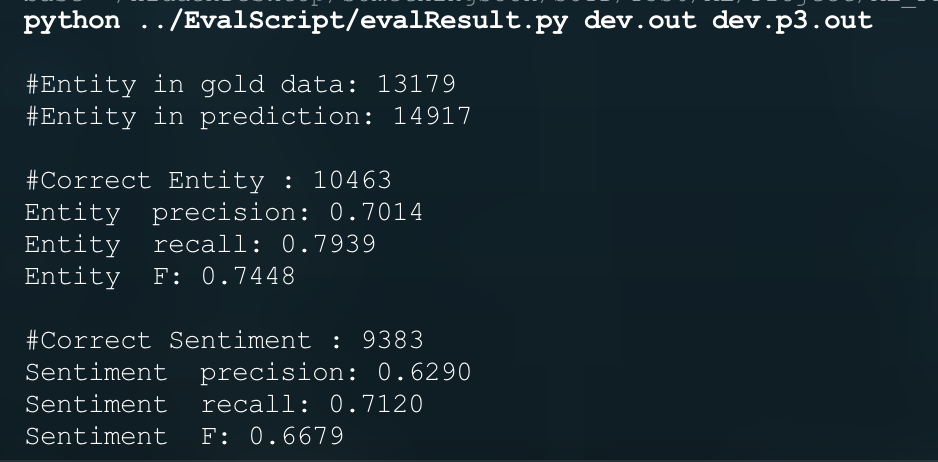

### Part 4